In [ ]:
# 심층 신경망 훈련하기

In [ ]:
# 그레디언트 소실과 폭주 문제

In [ ]:
# 글로럿과 벤지오의 해법
# 각 층의 출력에 대한 분산이 입력에 대한 분산과 같아야 한다고 주장했다
# 층의 입력의 개수(fan-in)과 출력의 개수(fan-out)이 같지 않으면 동일 분산이 보장되지 않음

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import sklearn
import matplotlib.pyplot as plt


In [ ]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [ ]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [ ]:
# - fan-in 대신 fan-out 기반의 균등분포 He 초기화를 사용할 때
# Variance Scaling 사용

In [ ]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)


In [ ]:
# ELU 활성화 함수

(-5.0, 5.0, -2.2, 3.2)

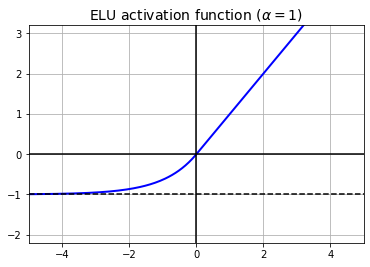

In [ ]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

z = np.linspace(-5, 5, 200)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])



In [ ]:
# Scaled ELU (SELU) 활성화 함수

(-5.0, 5.0, -2.2, 3.2)

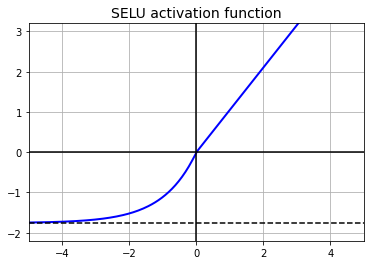

In [ ]:
from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화합니다
# (논문에 있는 식 14 참조):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])


In [ ]:
# SELU 실습

In [ ]:
Z = np.random.normal(size=(500, 100)) # 표준화된 입력
for layer in range(1000):
    # fan_in -> 100 
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun 초기화
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))


Layer 0: mean -0.00, std deviation 0.98
Layer 100: mean -0.03, std deviation 0.94
Layer 200: mean 0.01, std deviation 0.96
Layer 300: mean 0.05, std deviation 0.91
Layer 400: mean -0.04, std deviation 0.90
Layer 500: mean -0.04, std deviation 0.89
Layer 600: mean -0.03, std deviation 0.88
Layer 700: mean -0.01, std deviation 0.89
Layer 800: mean -0.04, std deviation 0.89
Layer 900: mean 0.04, std deviation 0.93


In [ ]:
'''
일반적으로 SELU > ELU > LeakyReLU(그리고 변종들) > ReLU > tanh > sigmoid 순
네트워크가 자기 정규화되지 못하는 구조라면 SELU 보단 ELU
실행 속도가 중요하다면 LeakyReLU(하이퍼파라미터를 더 추가하고 싶지 않다면 케라스에서 사용하는 기본값 α 사용)
시간과 컴퓨팅 파워가 충분하다면 교차 검증을 사용해 여러 활성화 함수를 평가
신경망이 과대적합되었다면 RReLU
훈련세트가 아주 크다면 PReLU
ReLU가 가장 널리 사용되는 활성화 함수이므로 많은 라이브러리와 하드웨어 가속기들이 ReLU에 특화되어 최적화
따라서 속도가 중요하다면 ReLU가 가장 좋은 선택
'''


In [ ]:
'''
LeakyReLU 활성화 함수 사용
LeakyReLU 층을 만들고 모델에서 적용하려는 층 뒤에 추가

PReLU 활성화 함수 사용
PReLU 층을 만들고 모델에서 적용하려는 층 뒤에 추가

ELU 활성화 함수 사용
층을 만들때 activation=’elu’ 지정

SELU 활성화 함수 사용
층을 만들때 activation=’selu’와 kernel_initializer=’lecun_normal’ 지정
'''

In [ ]:
# LeakyReLU로 패션 MNIST 훈련

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))


Epoch 1/10
1719/1719 [==============================] - 12s 6ms/step - loss: 1.2862 - accuracy: 0.6100 - val_loss: 0.8791 - val_accuracy: 0.7216
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7936 - accuracy: 0.7376 - val_loss: 0.7088 - val_accuracy: 0.7764
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6783 - accuracy: 0.7757 - val_loss: 0.6311 - val_accuracy: 0.8008
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6183 - accuracy: 0.7963 - val_loss: 0.5841 - val_accuracy: 0.8142
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5800 - accuracy: 0.8089 - val_loss: 0.5524 - val_accuracy: 0.8238
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5527 - accuracy: 0.8163 - val_loss: 0.5311 - val_accuracy: 0.8284
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5321 - accuracy: 0.8228 - val_loss: 0.5119 - val_accuracy

In [ ]:
# PReLU로 테스트 해보기

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.3403 - accuracy: 0.6000 - val_loss: 0.8965 - val_accuracy: 0.7194
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8075 - accuracy: 0.7355 - val_loss: 0.7170 - val_accuracy: 0.7752
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6884 - accuracy: 0.7772 - val_loss: 0.6359 - val_accuracy: 0.7956
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6245 - accuracy: 0.7982 - val_loss: 0.5863 - val_accuracy: 0.8100
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5833 - accuracy: 0.8095 - val_loss: 0.5550 - val_accuracy: 0.8156
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5548 - accuracy: 0.8157 - val_loss: 0.5293 - val_accuracy: 0.8246
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5333 - accuracy: 0.8209 - val_loss: 0.5116 - val_accuracy:

In [ ]:
# 100개의 은닉층으로 SELU사용

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
    
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])


In [ ]:
X_train.shape

(55000, 28, 28)

In [ ]:
# 입력의 평균 0, 표준편차 1로 변환

pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds
# 표준편차를 구할 때 valid set 과 test set은 이용하지 않는다 / train set만 이용

history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))


Epoch 1/5
1719/1719 [==============================] - 40s 21ms/step - loss: 1.1647 - accuracy: 0.5605 - val_loss: 0.8032 - val_accuracy: 0.6902
Epoch 2/5
1719/1719 [==============================] - 35s 20ms/step - loss: 0.7900 - accuracy: 0.7067 - val_loss: 0.7761 - val_accuracy: 0.7010
Epoch 3/5
1719/1719 [==============================] - 37s 21ms/step - loss: 0.7001 - accuracy: 0.7422 - val_loss: 0.6410 - val_accuracy: 0.7694
Epoch 4/5
1719/1719 [==============================] - 38s 22ms/step - loss: 0.6355 - accuracy: 0.7653 - val_loss: 0.6212 - val_accuracy: 0.7794
Epoch 5/5
1719/1719 [==============================] - 35s 20ms/step - loss: 0.5914 - accuracy: 0.7832 - val_loss: 0.5634 - val_accuracy: 0.8038


In [ ]:
# ReLU활성화 함수 사용

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

# 과대적합(??? 교수님 컴퓨터에선 과대적합)

Epoch 1/5
1719/1719 [==============================] - 27s 14ms/step - loss: 1.9692 - accuracy: 0.2187 - val_loss: 1.4255 - val_accuracy: 0.3746
Epoch 2/5
1719/1719 [==============================] - 23s 13ms/step - loss: 1.3715 - accuracy: 0.3958 - val_loss: 1.3197 - val_accuracy: 0.4462
Epoch 3/5
1719/1719 [==============================] - 24s 14ms/step - loss: 1.0027 - accuracy: 0.5734 - val_loss: 0.8890 - val_accuracy: 0.6280
Epoch 4/5
1719/1719 [==============================] - 22s 13ms/step - loss: 0.8188 - accuracy: 0.6723 - val_loss: 1.4557 - val_accuracy: 0.3988
Epoch 5/5
1719/1719 [==============================] - 23s 13ms/step - loss: 0.8708 - accuracy: 0.6581 - val_loss: 0.7458 - val_accuracy: 0.7210
